In [1]:
!ls

drive  sample_data


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
!ls

'00 keras 맛보기(학생 성적 데이테 예측_회귀).ipynb'
'01_keras 맛보기(폐암환자 생존 예측).ipynb'
'02_keras맛보기(유방암 데이터 분류).ipynb'
'03_keras맛보기(iris품종 분류).ipynb'
'04_손글씨 이미지 데이터 분류(keras).ipynb'
'05_패션 이미지 데이터 분류(keras).ipynb'
'06_사람얼굴 이진분류(keras).ipynb'
'07_활성화함수, 최적화함수 비교(패션데이터).ipynb'
'전대_08_네이버 영화리뷰 감성분석.ipynb'
'09_개, 고양이 사진분류(CNN).ipynb'
'Colaboratory에 오신 것을 환영합니다의 사본'
 data
 model
 Untitled0.ipynb


In [4]:
import numpy as np

In [5]:
data = np.load('./data/cats_dogs.npz')

In [6]:
len(data)

4

In [7]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [8]:
print(X_train.shape)    # 3채널 : 컬러
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 224, 224, 3)
(1000, 224, 224, 3)
(2000,)
(1000,)


CNN 모델링

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Conv2D : 컨볼루션 레이어
# MaxPool2D : 맥스 풀링 레이어
# 1차원 신호데이터는 Conv1D
# 2차원 이미지데이터는 Conv2D
# 3차원 영상데이터는 Conv3D

In [10]:
save_path = './model/Cats_Dogs_Model_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath=save_path, 
                         monitor ='val_acc',    # 해당 값 을 기준으로 파일을 저장
                         verbose = 1,           # 모델 개선 및 저장 메시지 표시 (0이면 표시x)
                         save_best_only = True    # monitor 값이 가장 최고점을 갱신 했을때 모델 저장
                         )

In [11]:
f_early = EarlyStopping(monitor='val_acc',
                        patience=5              #monitor 값 개선을 몇번이나 기다려 볼 것인지 설정
                        )

In [12]:
# 신경망 구조 설계
cat_dog_model = Sequential()

# 특성 추출부(Conv - 특징이 되는 정보를 추출)
cat_dog_model.add(Conv2D(input_shape=(224, 224, 3),
                         # 돋보기(필터) 개수 -> 추출하는 특징 개수 (32가지 특징 정보를 판단할 수 있음)
                         filters = 32,
                         # kernel_size : 필터(돋보기)의 크기를 설정
                         kernel_size=(5,5),
                         # 원래 들어온 데이터 크기에 맞게 알아서 padding이 적용
                         padding = 'same',
                         activation = 'relu'            
                         ))

cat_dog_model.add(Conv2D(filters = 64,
                         kernel_size=(5,5),
                         padding = 'same',
                         activation = 'relu'            
                         ))

# Dropout: 신경망 층 내부에서 과대적합을 막기위해 사용되는 기법
# (오차역전파 시 전체의 25% 신경망을 일시적으로 중단 시킴)
cat_dog_model.add(Dropout(0.25))

# 특성 추출부(Pooling - 불필요한 정보 삭제)
cat_dog_model.add(MaxPool2D(pool_size=2))     # pool_size 디폴트값은 2 - 2X2사이즈에 stride도 2씩 적용

# MLP 층

cat_dog_model.add(Flatten())
cat_dog_model.add(Dense(256, activation='relu'))
cat_dog_model.add(Dense(128, activation='relu'))
cat_dog_model.add(Dense(1, activation='sigmoid')) # cat/dog 이진분류
cat_dog_model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      51264     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 802816)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               205521152 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [13]:
# 학습/평가 방법 설정
cat_dog_model.compile(loss = 'binary_crossentropy',
                      optimizer=Adam(lr=0.001),
                      metrics=['acc']
                      )

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  random_state=7)

In [15]:
# 학습 - CNN은 MLP에 비해 연산속도가 더 느림
h1 = cat_dog_model.fit(X_train, y_train,
                       validation_data=(X_val,y_val),
                       epochs=100,
                       callbacks=[f_mckp, f_early]
                       )

Epoch 1/100
47/47 [==============================] - 14s 224ms/step - loss: 2110.1973 - acc: 0.5098 - val_loss: 0.6926 - val_acc: 0.5240

Epoch 00001: val_acc improved from -inf to 0.52400, saving model to ./model/Cats_Dogs_Model_001_0.5240.hdf5
Epoch 2/100
47/47 [==============================] - 9s 196ms/step - loss: 1.0942 - acc: 0.5636 - val_loss: 0.6949 - val_acc: 0.5340

Epoch 00002: val_acc improved from 0.52400 to 0.53400, saving model to ./model/Cats_Dogs_Model_002_0.5340.hdf5
Epoch 3/100
47/47 [==============================] - 9s 195ms/step - loss: 0.6613 - acc: 0.5780 - val_loss: 0.6951 - val_acc: 0.5340

Epoch 00003: val_acc did not improve from 0.53400
Epoch 4/100
47/47 [==============================] - 9s 198ms/step - loss: 0.6372 - acc: 0.6411 - val_loss: 0.7638 - val_acc: 0.5820

Epoch 00004: val_acc improved from 0.53400 to 0.58200, saving model to ./model/Cats_Dogs_Model_004_0.5820.hdf5
Epoch 5/100
47/47 [==============================] - 10s 211ms/step - loss: 0.45

<Figure size 1080x360 with 0 Axes>

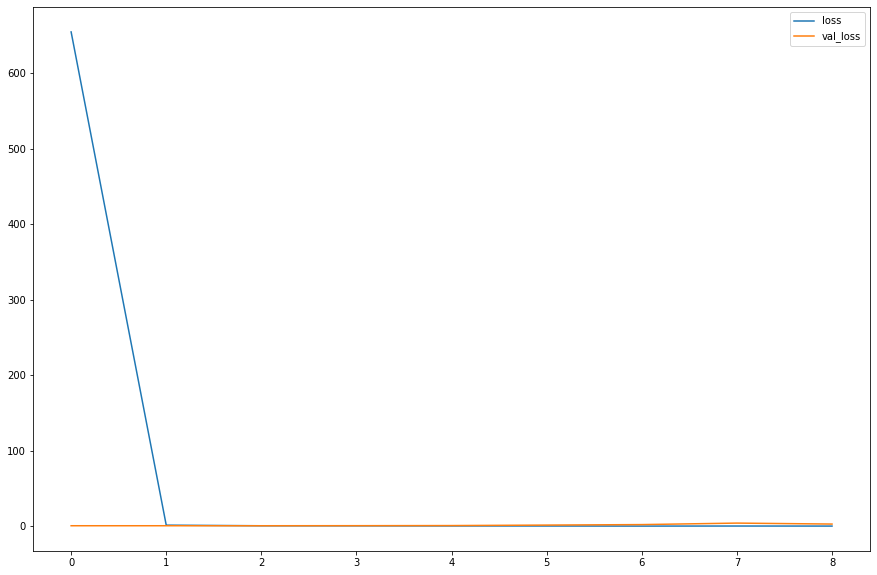

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.figure(figsize=(15,10))
plt.plot(h1.history['loss'],
         label = 'loss'
         )

plt.plot(h1.history['val_loss'],
         label = 'val_loss'
         )


plt.legend()
plt.show()

<Figure size 1080x360 with 0 Axes>

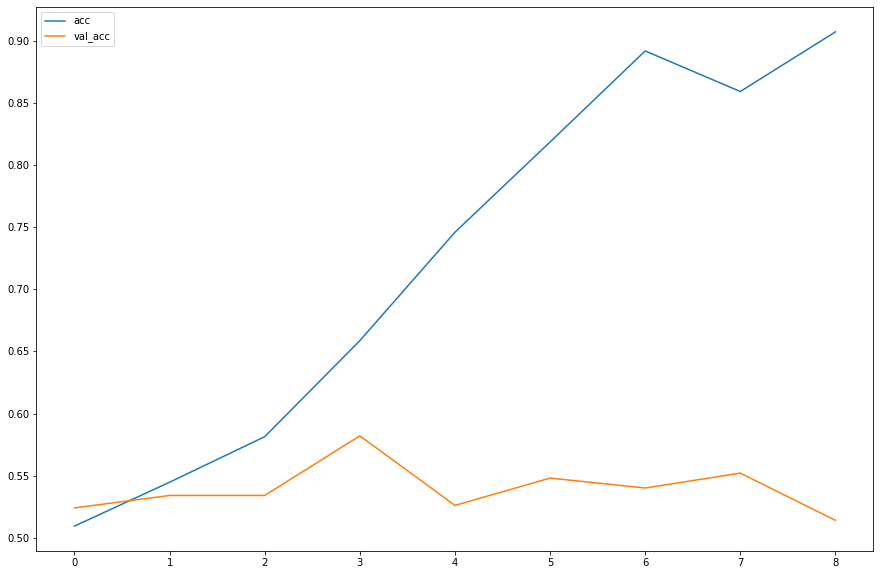

In [17]:
plt.figure(figsize=(15,5))
plt.figure(figsize=(15,10))
plt.plot(h1.history['acc'],
         label = 'acc'
         )

plt.plot(h1.history['val_acc'],
         label = 'val_acc'
         )


plt.legend()
plt.show()

- 개, 고양이 사진의 다양함과 데이터 규모에 비해서 Conv층과 Pooling 층이 너무 간단해서 제대로 된 결과가 나오지 않음

### VGG16 모델 적용 (전이학습)

In [34]:
from tensorflow.keras.applications import VGG16

In [35]:
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3)
              )

# include_top=False : MLP층을 제외하고 특징 추출부(Conv, Pooling)만 가져옴
# (기존 이미지넷 대화는 1000가지 이미지를 분류), 그러나 우리는 개, 고양이로만 분류
# weight='imagenet' : 이미지넷에서 학습된 가중치(w)를 그대로 가져옴

In [36]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
# 동결시킬 층을 확인하기 위해 vgg16 모델의 layer명들을 확인
for layer in vgg16.layers :
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [38]:
# 모델 설계
transfer_model = Sequential()

# 미세조정방식 적용(VGG16모델에서 맨 마지막 Conv층인 block5_conv3에만 학습이 가능하도록 설정)
# block5_conv3 외에 나머지 층들은 학습이 되지 않도록 동결
for layer in vgg16.layers :
  # block5_conv3 층만 학습이 가능하도록 설정
  if layer.name == 'block5_conv3' :
    layer.trainable = True
  # 나머지 층 동결 (학습불가)
  else :
    layer.trainable = False

# 로드한 VGG16 모델을 뼈대에 붙여줌
# 특징 추출부(VGG16모델의 특징 추출부에서 가져온 층들을 그대로 사용)
transfer_model.add(vgg16)

# MLP 층(우리 데이터에 맞게끔 변경)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dense(1, activation='sigmoid')) # cat/dog 이진분류
transfer_model.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 21,170,497
Trainable params: 8,815,617
Non-trainable params: 12,354,880
_________________________________________________________________


In [39]:
transfer_model.compile(loss = 'binary_crossentropy',
                      optimizer=Adam(lr=0.001),
                      metrics=['acc']
                      )

In [40]:
h2 = transfer_model.fit(X_train, y_train,
                       validation_data=(X_val,y_val),
                       epochs=90,
                       callbacks=[f_mckp, f_early]
                       )

Epoch 1/90
47/47 [==============================] - 9s 169ms/step - loss: 7.2490 - acc: 0.8081 - val_loss: 0.2316 - val_acc: 0.9600

Epoch 00001: val_acc improved from 0.66400 to 0.96000, saving model to ./model/Cats_Dogs_Model_001_0.9600.hdf5
Epoch 2/90
47/47 [==============================] - 8s 167ms/step - loss: 0.0356 - acc: 0.9916 - val_loss: 0.3492 - val_acc: 0.9440

Epoch 00002: val_acc did not improve from 0.96000
Epoch 3/90
47/47 [==============================] - 8s 169ms/step - loss: 0.0109 - acc: 0.9921 - val_loss: 0.2954 - val_acc: 0.9540

Epoch 00003: val_acc did not improve from 0.96000
Epoch 4/90
47/47 [==============================] - 8s 172ms/step - loss: 0.0061 - acc: 0.9981 - val_loss: 0.6969 - val_acc: 0.9380

Epoch 00004: val_acc did not improve from 0.96000
Epoch 5/90
47/47 [==============================] - 8s 175ms/step - loss: 0.1392 - acc: 0.9781 - val_loss: 1.3365 - val_acc: 0.9420

Epoch 00005: val_acc did not improve from 0.96000
Epoch 6/90
47/47 [======

### 학습이 제대로 되지 않고 있음
- MLP층애서 발생된 오차가 역전파를 통해 VGG16모델로 전달되면서 사전 학습된 정보(w,b) 많이 손실 될 수 있음
- 사전 학습 되어있는 w,b값을 변경되지 않도록
VGG16모델을 동결시켜놓고 MLP층을 추가로 학습시켜 비슷한 수준으로 맞춰줘야함
- Trainable params: 학습이 가능한 파라미터들 (동결을 시키게 되면 Nontrainable로 바뀍 됨)
- 특징 추출부에서 맨 마지막 층만 학습되게 변경
 - 좋은 특징 추출부가 MLP층이 망치고 있으니까 동결시켜놓고 일부 추출부만 사용